In [37]:
import os
import numpy as np
import cv2
from glob import glob
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Input
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
import matplotlib.pyplot as plt
from tqdm import tqdm
import urllib

In [38]:
def segnet_encoder(inputs):
    """ Encoder layers for SegNet """
    x = Conv2D(64, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    p1 = MaxPool2D((2, 2))(x)

    x = Conv2D(128, (3, 3), padding='same')(p1)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    p2 = MaxPool2D((2, 2))(x)

    x = Conv2D(256, (3, 3), padding='same')(p2)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    p3 = MaxPool2D((2, 2))(x)

    x = Conv2D(512, (3, 3), padding='same')(p3)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    p4 = MaxPool2D((2, 2))(x)

    return p4, [p3, p2, p1]

In [39]:
def segnet_decoder(inputs, encoder_features):
    """ Decoder layers for SegNet """
    p3, p2, p1 = encoder_features

    x = Conv2DTranspose(512, (3, 3), strides=2, padding='same')(inputs)
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2DTranspose(256, (3, 3), strides=2, padding='same')(x)
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2DTranspose(128, (3, 3), strides=2, padding='same')(x)
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2DTranspose(64, (3, 3), strides=2, padding='same')(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

In [40]:
def build_segnet(input_shape):
    inputs = Input(input_shape)
    encoder_output, encoder_features = segnet_encoder(inputs)
    decoder_output = segnet_decoder(encoder_output, encoder_features)
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(decoder_output)
    return Model(inputs, outputs, name="SegNet")

def load_data(dataset_path):
    images = sorted(glob(os.path.join(dataset_path, "images/*")))
    masks = sorted(glob(os.path.join(dataset_path, "masks/*")))
    train_x, test_x = train_test_split(images, test_size=0.2, random_state=42)
    train_y, test_y = train_test_split(masks, test_size=0.2, random_state=42)
    return (train_x, train_y), (test_x, test_y)

def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (256, 256))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (256, 256))
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    return x

def preprocess(image_path, mask_path):
    def f(image_path, mask_path):
        image_path = image_path.decode()
        mask_path = mask_path.decode()
        x = read_image(image_path)
        y = read_mask(mask_path)
        return x, y
    image, mask = tf.numpy_function(f, [image_path, mask_path], [tf.float32, tf.float32])
    image.set_shape([256, 256, 3])
    mask.set_shape([256, 256, 1])
    return image, mask

def tf_dataset(images, masks, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((images, masks))
    dataset = dataset.shuffle(buffer_size=5000)
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(2)
    dataset = dataset.repeat()
    return dataset

In [41]:

""" Hyperparameters """
dataset_path = "../input/person-segmentation/people_segmentation"
input_shape = (256, 256, 3)
batch_size = 8
epochs = 20
lr = 1e-4
model_path = "./segnet.keras"
csv_path = "./data_segnet.csv"

""" Loading the dataset """
(train_x, train_y), (test_x, test_y) = load_data(dataset_path)

train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(test_x, test_y, batch=batch_size)


In [42]:
""" Model """
model = build_segnet(input_shape)
model.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(lr),
    metrics=[
        tf.keras.metrics.MeanIoU(num_classes=2),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.Precision()
    ]
)

callbacks = [
    ModelCheckpoint(model_path, monitor="val_loss", verbose=1),
    ReduceLROnPlateau(monitor="val_loss", patience=5, factor=0.1, verbose=1),
    CSVLogger(csv_path),
    EarlyStopping(monitor="val_loss", patience=10)
]

# Добавляем CustomMetricsCallback
class CustomMetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_data):
        super(CustomMetricsCallback, self).__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        val_steps = valid_steps
        results = self.model.evaluate(self.validation_data, steps=val_steps, verbose=0)
        logs["val_precision"] = results[2]  # Precision
        logs["val_recall"] = results[3]     # Recall

callbacks.append(CustomMetricsCallback(valid_dataset))


In [43]:
train_steps = len(train_x) // batch_size
if len(train_x) % batch_size != 0:
    train_steps += 1

valid_steps = len(test_x) // batch_size
if len(test_x) % batch_size != 0:
    valid_steps += 1

model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=epochs,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks
)

Epoch 1/20
568/568 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.4371 - mean_io_u_8: 0.2667 - precision_8: 0.6304 - recall_8: 0.5604
Epoch 1: saving model to ./segnet.keras
568/568 ━━━━━━━━━━━━━━━━━━━━ 136s 215ms/step - loss: 0.4370 - mean_io_u_8: 0.2667 - precision_8: 0.6305 - recall_8: 0.5605 - val_loss: 0.5530 - val_mean_io_u_8: 0.2500 - val_precision_8: 0.5013 - val_recall_8: 0.8647 - learning_rate: 1.0000e-04 - val_precision: 0.8647 - val_recall: 0.5013
Epoch 2/20
568/568 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.3146 - mean_io_u_8: 0.2678 - precision_8: 0.7460 - recall_8: 0.6892
Epoch 2: saving model to ./segnet.keras
568/568 ━━━━━━━━━━━━━━━━━━━━ 116s 205ms/step - loss: 0.3145 - mean_io_u_8: 0.2678 - precision_8: 0.7461 - recall_8: 0.6893 - val_loss: 0.3069 - val_mean_io_u_8: 0.2500 - val_precision_8: 0.7008 - val_recall_8: 0.8137 - learning_rate: 1.0000e-04 - val_precision: 0.8137 - val_recall: 0.7008
Epoch 3/20
568/568 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.2730 - mean_

In [14]:
model.save("segnet_model.keras")



In [15]:
""" Testing """
test_images = [
    'https://raw.githubusercontent.com/nikhilroxtomar/Unet-for-Person-Segmentation/main/images/Black-Widow-Avengers.jpg'
]

model = tf.keras.models.load_model("./segnet.keras")
for path in tqdm(test_images, total=len(test_images)):
    req = urllib.request.urlopen(path)
    imgarr = np.asarray(bytearray(req.read()), dtype=np.uint8)
    x = cv2.imdecode(imgarr, -1)
    original_image = x
    h, w, _ = x.shape

    x = cv2.resize(x, (256, 256))
    x = x / 255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=0)

    pred_mask = model.predict(x)[0]
    pred_mask = cv2.resize(pred_mask, (w, h))
    pred_mask = np.expand_dims(pred_mask, axis=-1)
    pred_mask = pred_mask > 0.5

    background_mask = np.abs(1 - pred_mask)
    masked_image = original_image * pred_mask

    background_mask = np.concatenate([background_mask, background_mask, background_mask], axis=-1)
    background_mask = background_mask * [0, 0, 0]
    masked_image = masked_image + background_mask

    name = path.split("/")[-1]
    cv2.imwrite(f"{name}.png", masked_image)

  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 787ms/step


100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


In [44]:
log = pd.read_csv(csv_path)
print(log.columns)

Index(['epoch', 'learning_rate', 'loss', 'mean_io_u_8', 'precision_8',
       'recall_8', 'val_loss', 'val_mean_io_u_8', 'val_precision_8',
       'val_recall_8'],
      dtype='object')


Test Precision: 0.8739
Test Recall: 0.8751


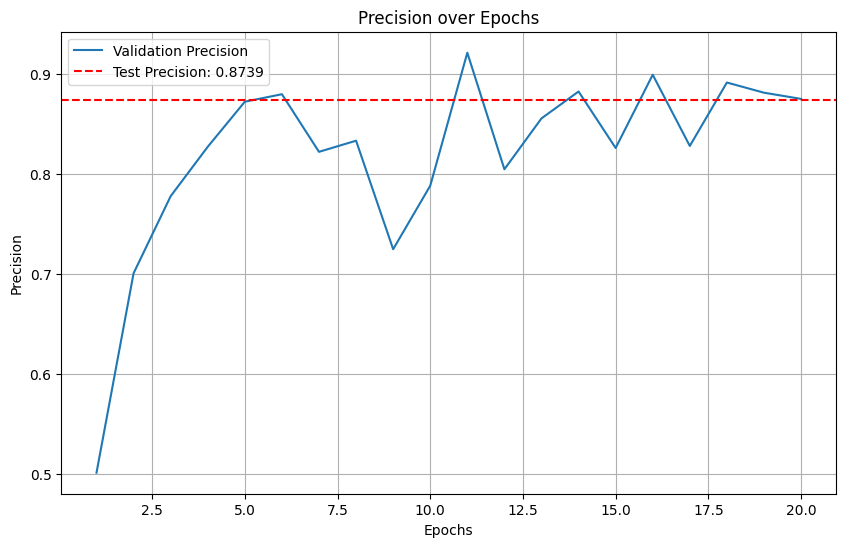

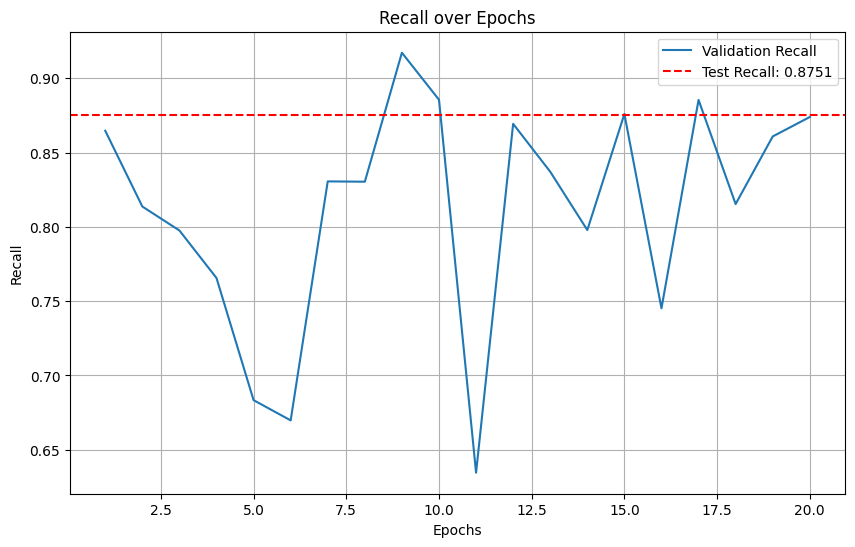

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_accuracy(csv_path, model, test_dataset, test_steps):
    """
    Строит график точности на валидационной выборке (из лога CSV) 
    и вычисляет точность на тестовой выборке.

    Args:
        csv_path (str): Путь к файлу лога CSV.
        model (tf.keras.Model): Обученная модель.
        test_dataset (tf.data.Dataset): Тестовый датасет.
        test_steps (int): Число шагов для тестового датасета.
    """
    # Загрузка лога CSV
    log = pd.read_csv(csv_path)
    
    # Метрики валидации из лога
    val_precision = log["val_precision_8"].values
    val_recall = log["val_recall_8"].values
    epochs = range(1, len(val_precision) + 1)
    
    # Вычисление точности на тестовом наборе
    results = model.evaluate(test_dataset, steps=test_steps, verbose=0)
    test_precision = results[2]  # Precision на тесте
    test_recall = results[3]     # Recall на тесте
    
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall: {test_recall:.4f}")
    
    # Построение графика
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, val_precision, label="Validation Precision")
    plt.axhline(y=test_precision, color='r', linestyle='--', label=f"Test Precision: {test_precision:.4f}")
    plt.title("Precision over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Precision")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, val_recall, label="Validation Recall")
    plt.axhline(y=test_recall, color='r', linestyle='--', label=f"Test Recall: {test_recall:.4f}")
    plt.title("Recall over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Recall")
    plt.legend()
    plt.grid(True)
    plt.show()

# Пример вызова:
plot_accuracy(csv_path="./data_segnet.csv", model=model, test_dataset=valid_dataset, test_steps=valid_steps)
